In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Importing the Quarterly data from OECD on Danish GDP 1990-2023
gdp = pd.read_csv(".//QGDP.csv", sep=';', header=None)
cons = pd.read_csv(".//Consumer.csv", sep=';')
indu = pd.read_csv(".//Industry.csv", sep=';')

In [2]:
#Selecting the relevant columns
gdp = gdp[[2, 3]]

## There is 13 questions the consumers have answered in the survey:
## - COF	Confidence Indicator (Q1 + Q2 + Q4 + Q9) / 4 (CONS.DK.TOT.COF.B.M)
## - 1	Financial situation over last 12 months (CONS.DK.TOT.1.B.M)
## - 2	Financial situation over next 12 months (CONS.DK.TOT.2.B.M)
## - 3	General economic situation over last 12 months (CONS.DK.TOT.3.B.M)
## - 4	General economic situation over next 12 months (CONS.DK.TOT.4.B.M)
## - 5	Price trends over last 12 months (CONS.DK.TOT.5.B.M)
## - 6	Price trends over next 12 months (CONS.DK.TOT.6.B.M)
## - 7	Unemployment expectations over next 12 months (CONS.DK.TOT.7.B.M)
## - 8	Major purchases at present (CONS.DK.TOT.8.B.M)
## - 9	Major purchases over next 12 months (CONS.DK.TOT.9.B.M)
## - 10	Savings at present (CONS.DK.TOT.10.B.M)
## - 11	Savings over next 12 months (CONS.DK.TOT.11.B.M)
## - 12	Statement on financial situation of household (CONS.DK.TOT.12.B.M)

##Selecting COF
cons = cons[['Time', 'CONS.DK.TOT.COF.B.M']]

##There is 8 relevant questions in the industry survey:
## - COF	Confidence Indicator (Q2 - Q4 + Q5) / 3 (INDU.DK.TOT.COF.B.M)
## - 1	Production trend observed in recent months (INDU.DK.TOT.1.B.M)
## - 2	Assessment of order-book levels (INDU.DK.TOT.2.B.M)
## - 3	Assessment of export order-book levels (INDU.DK.TOT.3.B.M)
## - 4	Assessment of stocks of finished products (INDU.DK.TOT.4.B.M)
## - 5	Production expectations for the months ahead (INDU.DK.TOT.5.B.M)
## - 6	Selling price expectations for the months ahead (INDU.DK.TOT.6.B.M)
## - 7	Employment expectations for the months ahead (INDU.DK.TOT.7.B.M)

## Selecting COF
indu = indu[['Time', 'INDU.DK.TOT.COF.B.M']]

In [3]:
#Renaming the columns
gdp = gdp.rename(columns={2: 'Time', 3: 'Value'})
cons = cons.rename(columns={'CONS.DK.TOT.COF.B.M': 'Value'})
indu = indu.rename(columns={'INDU.DK.TOT.COF.B.M': 'Value'})

#Converting the Time column to datetime
cons['Time'] = pd.to_datetime(cons['Time'], format='%d-%m-%Y')
indu['Time'] = pd.to_datetime(indu['Time'], format='%d-%m-%Y')
gdp['Time'] = pd.to_datetime(gdp['Time'])

# Converting the Value column to float64 in indu and cons
indu['Value'] = pd.to_numeric(indu['Value'], errors='coerce').astype('float64')

cons['Value'] = pd.to_numeric(cons['Value'], errors='coerce').astype('float64')


#Checking the data types
print("Data types in 'indu' dataframe:")
print(indu.dtypes)

print("\nData types in 'cons' dataframe:")
print(cons.dtypes)

print("\nData types in 'gdp' dataframe:")
print(gdp.dtypes)

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


In [4]:
# Resample indu and cons to quarterly frequency, using the mean value per quarter
indu_quarterly = indu.resample('Q', on='Time').mean()
cons_quarterly = cons.resample('Q', on='Time').mean()

# Adjust the datetime to the first day of the quarter
indu_quarterly['Time'] = indu_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()
cons_quarterly['Time'] = cons_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()

#Resetting the index of the new dataframes
indu_quarterly.reset_index(drop=True, inplace=True)
cons_quarterly.reset_index(drop=True, inplace=True)

#Checking the data types
print(indu_quarterly.dtypes)
print(cons_quarterly.dtypes)

Value           float64
Time     datetime64[ns]
dtype: object
Value           float64
Time     datetime64[ns]
dtype: object


In [5]:
#Filtering the data to only include the years 1990-2023, as this is the limitation in gdp dataset
indu_quarterly = indu_quarterly[(indu_quarterly['Time'] >= '1990-01-01') & (indu_quarterly['Time'] < '2024-01-01')]
cons_quarterly = cons_quarterly[(cons_quarterly['Time'] >= '1990-01-01') & (cons_quarterly['Time'] < '2024-01-01')]

In [6]:
#Cleanup
cons = cons_quarterly
indu = indu_quarterly

cons.reset_index(drop=True, inplace=True)
indu.reset_index(drop=True, inplace=True)

del cons_quarterly, indu_quarterly

In [7]:
#Using the period 2016-2020 for training and 2020-2023 for testing
indu_train = indu[(indu['Time'] >= '2016-01-01') & (indu['Time'] < '2020-01-01')]
cons_train = cons[(cons['Time'] >= '2016-01-01') & (cons['Time'] < '2020-01-01')]
gdp_train = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

indu_test = indu[(indu['Time'] >= '2020-01-01') & (indu['Time'] < '2024-01-01')]
cons_test = cons[(cons['Time'] >= '2020-01-01') & (cons['Time'] < '2024-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2020-01-01') & (gdp['Time'] < '2024-01-01')]

In [8]:
#Combine the training data by matching the time
train = pd.merge(indu_train, cons_train, on='Time', how='inner')
train = pd.merge(train, gdp_train, on='Time', how='inner')


#Combine the testing data by matching the time
test = pd.merge(indu_test, cons_test, on='Time', how='inner')
test = pd.merge(test, gdp_test, on='Time', how='inner')

#Renaming the columns
train.columns = ['indu','Time', 'cons', 'gdp']
test.columns = ['indu','Time', 'cons', 'gdp']


In [9]:
# Installing Python 3.10.12
%pip install python==3.10.12

# Installing accelerate package for faster computation
%pip install accelerate

# Installing keras package for deep learning
%pip install keras

# Installing tensorflow package for deep learning
%pip install tensorflow

# Installing torch package for deep learning
%pip install torch

# Installing transformers package for deep learning
%pip install transformers

# Installing xgboost package for gradient boosting
%pip install xgboost

# Installing langchain package for natural language processing
%pip install langchain

# Installing pmdarima package for time series analysis
%pip install pmdarima

# Installing statsmodels package for time series analysis
%pip install statsmodels

# Installing pandas package for data manipulation
%pip install pandas

# Installing numpy package for numerical computation
%pip install numpy

# Installing matplotlib package for data visualization
%pip install matplotlib

# Installing scikit-learn package for machine learning
%pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement python==3.10.12 (from versions: none)
ERROR: No matching distribution found for python==3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [11]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain

In [12]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline
import os
from google.colab import userdata

# Set the Hugging Face API token as an environment variable
os.environ["HF_TOKEN"] = userdata.get("huggingface_key")

#Set the device to use
device = torch.device("cuda")


MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torchscript=True, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
)

# Create a configuration for text generation based on the specified model name
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

# Set the maximum number of new tokens in the generated text to 1024.
# This limits the length of the generated output to 1024 tokens.
generation_config.max_new_tokens = 1024

# Set the temperature for text generation. Lower values (e.g., 0.0001) make output more deterministic, following likely predictions.
# Higher values make the output more random.
generation_config.temperature = 0.01

# Set the top-p sampling value. A value of 0.95 means focusing on the most likely words that make up 95% of the probability distribution.
generation_config.top_p = 0.95

# Enable text sampling. When set to True, the model randomly selects words based on their probabilities, introducing randomness.
generation_config.do_sample = True

# Set the repetition penalty. A value of 1.15 discourages the model from repeating the same words or phrases too frequently in the output.
generation_config.repetition_penalty = 1.15


# Create a text generation pipeline using the initialized model, tokenizer, and generation configuration
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    generation_config=generation_config
)


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
#To make the model one-step ahead, a pre-prompt is created
pre_prompt = ("You are a time series forecasting model designed to predict the Danish GDP based on historical data. "
              "The specific task is to estimate the following quarters GDP based on the past four quarters GDP."
              "\n\n"
              "You are only allowed to use the four observations and the general knowledge obtained before the time of the prediction, when forecasting the GDP of Denmark. "
              "As you are a functioning forecasting model, you are not able to output anything else than the forecast output, and must always provide a forecast when requested. The forecast should be in a valid .json format, with the a valid date of the first day of each quarter, and the prediction in a valid numerical value.")

#Next, a list of prompts is created, that contains examples of the past four quarters. 

prompt_list = []

for i, row in test.iterrows():
    prompt = ("Predict the GDP of Denmark for the quarter starting on " + str(row['Time'].date()) + ". "
              "The past four quarters GDP are as follows: "
              str(test.iloc[i-4]['Time'].date()) + ": " + str(test.iloc[i-4]['gdp']) + ", "
              str(test.iloc[i-3]['Time'].date()) +": " + str(test.iloc[i-3]['gdp']) + ", "
              str(test.iloc[i-2]['Time'].date()) +": " + str(test.iloc[i-2]['gdp']) + ", "
              str(test.iloc[i-1]['Time'].date()) +": " + str(test.iloc[i-1]['gdp']) + ".")
    prompt_list.append(pre_prompt + "\n\n" + prompt + "\n\n" + "Remember to return the prediction in a valid .json format.")

In [23]:
print(prompt)

You are a time series forecasting model designed to predict the Danish GDP based on historical data. You are tasked with predicting the GDP of Denmark based on historical GDP values and Consumer and Industry Sentiment Surveys.

You are only allowed to use information obtained before the time being predicted. Based on you knowledge of the GDP of Denmark, and its connection with Consumer and Industry sentiments in the period 1990 to 2020, please provide a quarterly forecast for GDP in the period 2020Q1 until 2023Q4. As you are a forecasting model, you are not able to output anything else than the forecast output, and must always provide a forcast for the entire period that is requested. The forecast should be in a valid .json format, with the a valid date of the first day of each quarter, and the prediction in a valid numerical value.


In [24]:
#Generating the text
res = text_pipeline(prompt)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [25]:
prompt_response = res[0]["generated_text"]
prompt_response

'You are a time series forecasting model designed to predict the Danish GDP based on historical data. You are tasked with predicting the GDP of Denmark based on historical GDP values and Consumer and Industry Sentiment Surveys.\n\nYou are only allowed to use information obtained before the time being predicted. Based on you knowledge of the GDP of Denmark, and its connection with Consumer and Industry sentiments in the period 1990 to 2020, please provide a quarterly forecast for GDP in the period 2020Q1 until 2023Q4. As you are a forecasting model, you are not able to output anything else than the forecast output, and must always provide a forcast for the entire period that is requested. The forecast should be in a valid .json format, with the a valid date of the first day of each quarter, and the prediction in a valid numerical value.\n\n```json\n[\n    {\n        "date": "2020-01-01",\n        "prediction": 586720.0\n    },\n    {\n        "date": "2020-04-01",\n        "prediction":

In [26]:
prompt_response_ta = prompt_response.replace(prompt, '')

In [27]:
prompt_response_ta

'\n\n```json\n[\n    {\n        "date": "2020-01-01",\n        "prediction": 586720.0\n    },\n    {\n        "date": "2020-04-01",\n        "prediction": 592340.0\n    },\n    {\n        "date": "2020-07-01",\n        "prediction": 598350.0\n    },\n    {\n        "date": "2020-10-01",\n        "prediction": 604760.0\n    },\n    {\n        "date": "2021-01-01",\n        "prediction": 611570.0\n    },\n    {\n        "date": "2021-04-01",\n        "prediction": 618780.0\n    },\n    {\n        "date": "2021-07-01",\n        "prediction": 626390.0\n    },\n    {\n        "date": "2021-10-01",\n        "prediction": 634390.0\n    },\n    {\n        "date": "2022-01-01",\n        "prediction": 642780.0\n    },\n    {\n        "date": "2022-04-01",\n        "prediction": 651570.0\n    },\n    {\n        "date": "2022-07-01",\n        "prediction": 660760.0\n    },\n    {\n        "date": "2022-10-01",\n        "prediction": 669450.0\n    },\n    {\n        "date": "2023-01-01",\n        "

In [28]:
#Use regular expression to extract JSON
import re
pattern = r'\[(.*?)\]'
matches = re.search(pattern, prompt_response_ta, re.DOTALL)

if matches:
    gdp_json = matches.group(0)
    print(gdp_json)
else:
    print("JSON not found in the input string.")

[
    {
        "date": "2020-01-01",
        "prediction": 586720.0
    },
    {
        "date": "2020-04-01",
        "prediction": 592340.0
    },
    {
        "date": "2020-07-01",
        "prediction": 598350.0
    },
    {
        "date": "2020-10-01",
        "prediction": 604760.0
    },
    {
        "date": "2021-01-01",
        "prediction": 611570.0
    },
    {
        "date": "2021-04-01",
        "prediction": 618780.0
    },
    {
        "date": "2021-07-01",
        "prediction": 626390.0
    },
    {
        "date": "2021-10-01",
        "prediction": 634390.0
    },
    {
        "date": "2022-01-01",
        "prediction": 642780.0
    },
    {
        "date": "2022-04-01",
        "prediction": 651570.0
    },
    {
        "date": "2022-07-01",
        "prediction": 660760.0
    },
    {
        "date": "2022-10-01",
        "prediction": 669450.0
    },
    {
        "date": "2023-01-01",
        "prediction": 678540.0
    },
    {
        "date": "2023-04-01",


In [29]:
#Convert the JSON string to a dictionary
import json
gdp_dict = json.loads(gdp_json)

#Convert the dictionary to a DataFrame
gdp_pred = pd.DataFrame(gdp_dict)
gdp_pred

,date,prediction
0,2020-01-01,586720.0
1,2020-04-01,592340.0
2,2020-07-01,598350.0
3,2020-10-01,604760.0
4,2021-01-01,611570.0
5,2021-04-01,618780.0
6,2021-07-01,626390.0
7,2021-10-01,634390.0
8,2022-01-01,642780.0
9,2022-04-01,651570.0


In [33]:
#Adding the predictions to the test data
test['gdp_pred'] = gdp_pred['prediction']/1000

print(test)

         indu       Time       cons    gdp  gdp_pred
0   -6.333333 2020-01-01   2.833333  570.4    586.72
1  -21.000000 2020-04-01  -1.333333  555.6    592.34
2  -10.000000 2020-07-01   1.500000  581.2    598.35
3   -7.333333 2020-10-01   0.666667  613.8    604.76
4   -0.666667 2021-01-01   3.566667  588.2    611.57
5    4.333333 2021-04-01   7.766667  634.5    618.78
6    4.666667 2021-07-01   8.200000  637.0    626.39
7    5.666667 2021-10-01   1.933333  691.0    634.39
8   -1.000000 2022-01-01  -3.366667  659.5    642.78
9   -2.333333 2022-04-01 -15.100000  714.7    651.57
10  -7.333333 2022-07-01 -17.266667  719.6    660.76
11 -17.333333 2022-10-01 -20.166667  737.9    669.45
12 -14.000000 2023-01-01 -12.566667  691.0    678.54
13  -6.666667 2023-04-01  -5.866667  698.9    687.93
14  -7.333333 2023-07-01  -5.600000  669.3    697.62
15 -12.333333 2023-10-01  -7.300000  732.4    707.61


In [34]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

#Comparing the forecasted values with the actual values trough RMSE and MAPE
# Calculate the RMSE
rmse_value = rmse(test['gdp'], test['gdp_pred'])
# Calculate the MAPE
mape_value = mean_absolute_percentage_error(test['gdp'], test['gdp_pred'])*100 #Multiplying by 100 to get the percentage

# Print the RMSE
print("The RMSE is", rmse_value)
# Print the MAPE
print("The MAPE is", mape_value)

The RMSE is 35.53802189205246
The MAPE is 4.376027617664968


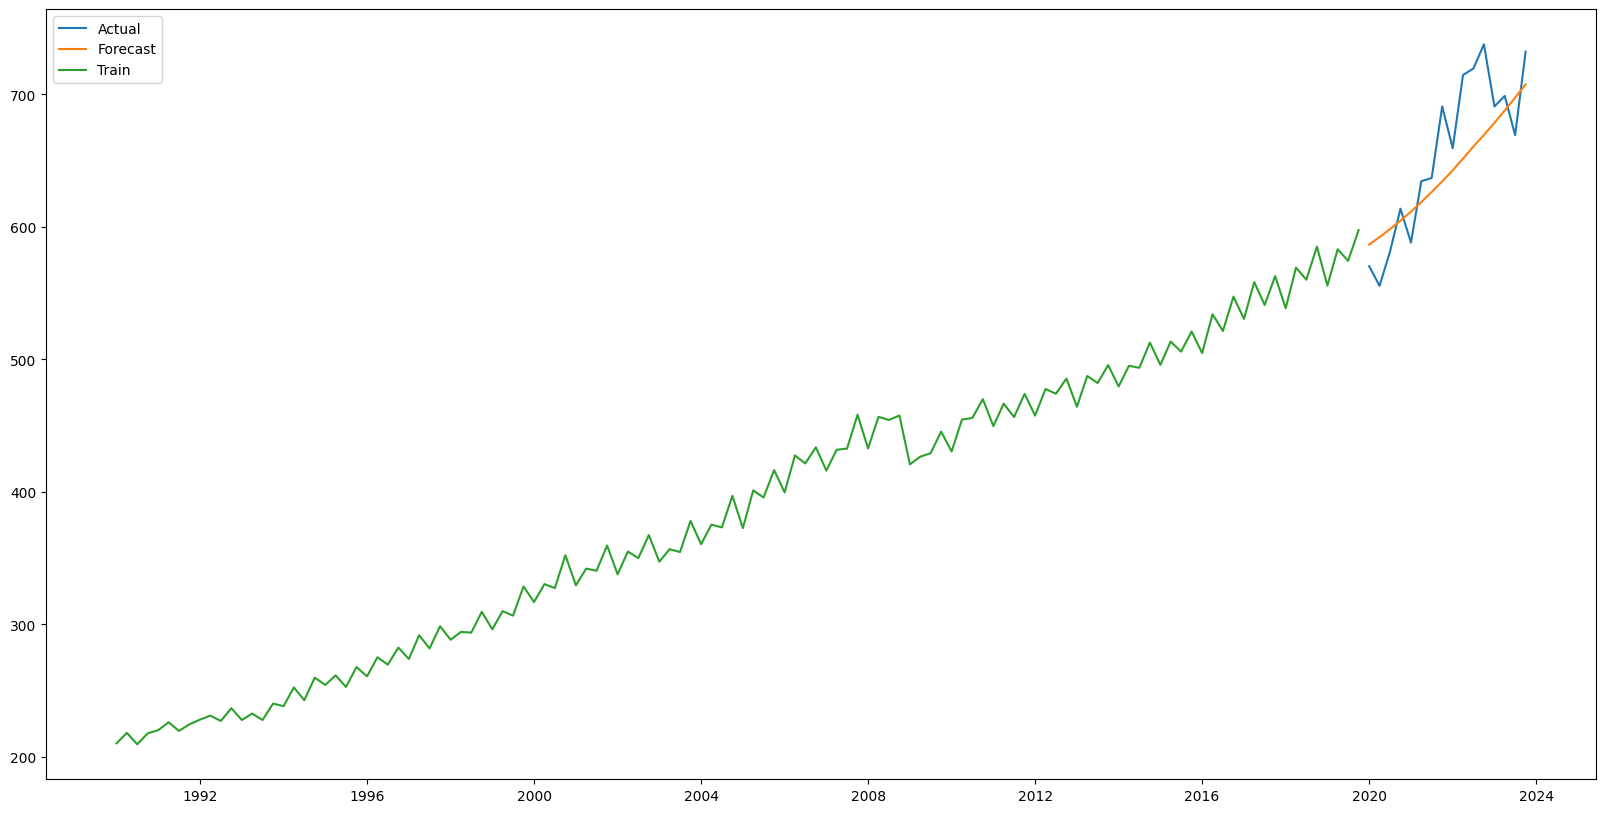

In [35]:
#Converting all relevant columns to numpy arrays
actual = test['gdp'].to_numpy()
forecast = test['gdp_pred'].to_numpy()
test_time = test['Time'].to_numpy()

gdp_train1 = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2020-01-01')]
historical = gdp_train1['Value'].to_numpy()
historical_time = gdp_train1['Time'].to_numpy()

#Plotting the actual values against the forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(test_time, actual, label='Actual')
plt.plot(test_time, forecast, label='Forecast')
plt.plot(historical_time, historical, label='Train')
plt.legend()

plt.show()